In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
#from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import pickle
!pip install xlwt
#import nltk
#nltk.download('wordnet')

In [2]:
events = pd.read_excel("Event.xlsx")
target_names = events.Type.unique().tolist()

In [3]:
events

,Events,Type,Unnamed: 2
0,Management 2020 hackathon is out,Management.Hackathons,NaN
1,Attend a mangament hackathon of your choosing,Management.Hackathons,NaN
2,Hackathons and more: Management hackathon is h...,Management.Hackathons,NaN
3,Introducing The Management 2.0 Hackathon,Management.Hackathons,NaN
4,Join us live online on September 10th at 9:30 ...,Management.Webinars,NaN
...,...,...,...
1890,Workshops - The Ai workshop is here,Artificial_Intelligence.Workshops,NaN
1891,Sign up for an Artificial Intelligence worksho...,Artificial_Intelligence.Workshops,NaN
1892,Limited time discount on any of our artificial...,Artificial_Intelligence.Workshops,NaN
1893,AI Workshops | The AMDR artificial intelligenc...,Artificial_Intelligence.Workshops,NaN


In [4]:
events['category_id'] = events['Type'].factorize()[0]

In [5]:
category_id_df = events[['Type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Type']].values)

In [6]:
def split_lemma(event_list):#stemmer = SnowballStemmer("english")
    stemmer = SnowballStemmer("english")
    #lemma = WordNetLemmatizer()

    output = []
    for sentence in event_list:
        output.append(" ".join([stemmer.stem(i) for i in sentence.split()]))
    return output
events['Events_stemmed'] = split_lemma(events.Events)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text


my_stops = text.ENGLISH_STOP_WORDS.difference(["AI", "ai"])

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words= my_stops, token_pattern = r"(?u)c\+{2}|\b\w+\b")
features = tfidf.fit_transform(events.Events_stemmed.values)
#features = tfidf.fit_transform(events.Events.values)
labels = events.Type
features.shape


(1895, 406)

In [8]:
pickle.dump(tfidf, open("tfidf.pickle", "wb"))

C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\shiva\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), U

NameError: name 'plt' is not defined

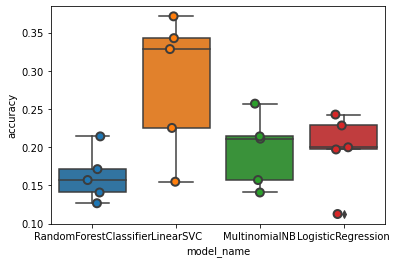

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [26]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, events.index, test_size=0.1, random_state=0)

In [16]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.mean(y_pred == y_test))

0.5217391304347826


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

KeyboardInterrupt: 

In [9]:
model = LinearSVC()

model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [10]:
pickle.dump(model, open("model.sav", "wb"))

In [15]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Artificial_Intelligence.Certifications':
  . Top unigrams:
       . internship
       . c
  . Top bigrams:
       . c programming
       . sign today
# 'Artificial_Intelligence.Courses':
  . Top unigrams:
       . project
       . c
  . Top bigrams:
       . job opening
       . naukri com
# 'Artificial_Intelligence.Expos':
  . Top unigrams:
       . fest
       . c
  . Top bigrams:
       . c language
       . c programming
# 'Artificial_Intelligence.Fests':
  . Top unigrams:
       . course
       . date
  . Top bigrams:
       . join course
       . objective c
# 'Artificial_Intelligence.Hackathons':
  . Top unigrams:
       . certified
       . c
  . Top bigrams:
       . developer today
       . c programming
# 'Artificial_Intelligence.Internships':
  . Top unigrams:
       . popular
       . c
  . Top bigrams:
       . talk series
       . talks speeches
# 'Artificial_Intelligence.Jobs':
  . Top unigrams:
       . c
       . conference
  . Top bigrams:
       . conferences sem

# 'Higher_Education.Workshops':
  . Top unigrams:
       . development
       . certifications
  . Top bigrams:
       . advanced certification
       . certifications available
# 'IoT.Certifications':
  . Top unigrams:
       . javascript
       . js
  . Top bigrams:
       . javascript fair
       . fairs expos
# 'IoT.Competitions':
  . Top unigrams:
       . complex
       . java
  . Top bigrams:
       . join java
       . hackathons codeathons
# 'IoT.Courses':
  . Top unigrams:
       . java
       . compete
  . Top bigrams:
       . java competition
       . win exciting
# 'IoT.Expos':
  . Top unigrams:
       . web
       . website
  . Top bigrams:
       . development fest
       . love website
# 'IoT.Fests':
  . Top unigrams:
       . iot
       . workshop
  . Top bigrams:
       . iot fair
       . internet things
# 'IoT.Hackathons':
  . Top unigrams:
       . iot
       . things
  . Top bigrams:
       . iot training
       . internet device
# 'IoT.Internships':
  . Top unig

# 'Mobile_Applications.Internships':
  . Top unigrams:
       . enterprise
       . c++
  . Top bigrams:
       . internship available
       . stand peer
# 'Mobile_Applications.Jobs':
  . Top unigrams:
       . festival
       . weekend
  . Top bigrams:
       . annual c++
       . c++ enthusiasts
# 'Mobile_Applications.Seminars':
  . Top unigrams:
       . c++
       . plethora
  . Top bigrams:
       . quiz stand
       . don t
# 'Mobile_Applications.Talks':
  . Top unigrams:
       . seminars
       . conference
  . Top bigrams:
       . modern c++
       . seminar series
# 'Mobile_Applications.Trainings':
  . Top unigrams:
       . challenge
       . core
  . Top bigrams:
       . c++ hackathon
       . hackathon stand
# 'Mobile_Applications.Webinars':
  . Top unigrams:
       . better
       . programming
  . Top bigrams:
       . talks speeches
       . attend speech
# 'Mobile_Applications.Workshops':
  . Top unigrams:
       . c++
       . practises
  . Top bigrams:
       . c+

In [44]:
id_to_category

{0: 'Management.Hackathons',
 1: 'Management.Webinars',
 2: 'Coding.Hackathons',
 3: 'Other.Hackathons',
 4: 'Coding.Webinars',
 5: 'Coding.Seminars',
 6: 'Security.Webinars',
 7: 'Security.Seminars',
 8: 'Other.Certifications',
 9: 'Security.Certifications',
 10: 'Other.Competitions',
 11: 'Management.Trainings',
 12: 'Other.Webinar',
 13: 'Higher_Education.Trainings',
 14: 'Higher_Education.Internships',
 15: 'Higher_Education.Webinars',
 16: 'Higher_Education.Expos',
 17: 'Higher_Education.Seminars',
 18: 'Management.Expos',
 19: 'Coding.Fests',
 20: 'Coding.Internships',
 21: 'Coding.Jobs',
 22: 'Coding.Expos',
 23: 'Coding.Certifications',
 24: 'Coding.Talks',
 25: 'Coding.Competitions',
 26: 'Artificial_Intelligence.Hackathons',
 27: 'Artificial_Intelligence.Webinars',
 28: 'Artificial_Intelligence.Fests',
 29: 'Artificial_Intelligence.Seminars',
 30: 'Artificial_Intelligence.Expos',
 31: 'Artificial_Intelligence.Certifications',
 32: 'Artificial_Intelligence.Trainings',
 33: 'Ar

In [28]:
texts = ["Get a job as a senior Python Developer Now with our certification!",
         "The World's largest python conference is out now",
         "Expo: The advent of ai",
         "Stand out with this comprehensive course on finance and investments",
         "COHO C++ Festival and competition begins soon. Book your Tickets today!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(predicted))
  print("")

"Get a job as a senior Python Developer Now with our certification!"
  - Predicted as: 'Python.Jobs'

"The World's largest python conference is out now"
  - Predicted as: 'Python.Seminars'

"Expo: The advent of ai"
  - Predicted as: 'Artificial_Intelligence.Expos'

"Stand out with this comprehensive course on finance and investments"
  - Predicted as: 'Finance.Courses'

"COHO C++ Festival and competition begins soon. Book your Tickets today!"
  - Predicted as: 'Mobile_Applications.Fests'



In [13]:
from sklearn.feature_extraction import text
my_stops = text.ENGLISH_STOP_WORDS.difference(["AI", "ai"])

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=my_stops)

X = vectorizer.fit_transform(["this is an AI apple.","get your ai course today"])

idf_values = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# printing the tfidf vectors
print(X)

# printing the vocabulary
print(vectorizer.vocabulary_)

  (0, 1)	0.8148024746671689
  (0, 0)	0.5797386715376657
  (1, 3)	0.6316672017376245
  (1, 2)	0.6316672017376245
  (1, 0)	0.4494364165239821
{'ai': 0, 'apple': 1, 'course': 2, 'today': 3}


In [14]:
def get_query(event_dom, event_type, employees):
    return employees.query("Domain == '" + event_dom + "' and (Event1 == '" + event_type +"' or Event2 == '" + event_type + "')")

In [12]:
def predict(events, employees):
    #for event in events:
        #print(type(event))
        recommendations = []
        pred = model.predict(tfidf.transform(events))
        
        for text, predicted in zip(events, pred):
          print('"{}"'.format(text))
          print("  - Predicted as: '{}'".format(predicted))
          print("")
        
        for prediction in pred.tolist():
            domain, event_type = prediction.split(".")
            if domain == 'Artificial_Intelligence':
                #recommend_to = employees.loc[employees['Domain'] == "Artificial Intelligence" and (employees['Event1'] == event_type or employees['Event2'] == event_type) , 'Name'].all()
                recommend_to = get_query('Artificial Intelligence', event_type, employees)
                
            elif domain == 'WebDev':
                recommend_to = get_query('Web Development', event_type, employees)
                
            elif domain == 'Mobile_Applications':
                recommend_to = get_query('Mobile Applications', event_type, employees)
                
            elif domain == 'ML':
                recommend_to = get_query('Machine Learning', event_type, employees)
                
            elif domain == 'CC':
                recommend_to = get_query('Cloud Computing', event_type, employees)
                
            elif domain == 'Higher_Education':
                recommend_to = get_query('Higher Education', event_type, employees)
                
            elif domain == 'DevOps':
                recommend_to = get_query('Development Processes', event_type, employees)
                
            elif domain == 'Software_Architecture':
                recommend_to = get_query('Software Architecture', event_type, employees)
                
            elif domain == 'Data_Science':
                recommend_to = get_query('Data Science', event_type, employees)
                
            elif domain == 'Cpp':
                recommend_to = get_query('C++', event_type, employees)
                
            elif domain == 'None':
                recommend_to = employees.query("Event1 == '" + event_type + "' or Event2 == '" + event_type + "'")
                
            else:
                recommend_to = get_query(domain, event_type, employees)
                
            recommendations.append(", ".join(recommend_to['Name'].values))
            
        return recommendations

In [13]:
def make_predictions():
    employees = pd.read_csv("CCMLEmployeeData.csv")
    
    to_pred = input("Please enter the file: ")
    
    to_pred_events = pd.read_csv(to_pred)
    to_pred_sent = split_lemma(to_pred_events.iloc[:,0])
    recommendations = predict(to_pred_sent, employees)
    #print(recommendations)
    to_pred_events['Employees'] = recommendations
    with open("output.xls", 'w'):
        to_pred_events.to_excel("output.xls", index=False)

In [15]:
make_predictions()

Please enter the file: event_test.csv
"get a job as a senior python develop now!"
  - Predicted as: 'Python.Jobs'

"the world largest python confer is out now"
  - Predicted as: 'Python.Seminars'

"expo: the advent of ai"
  - Predicted as: 'Artificial_Intelligence.Expos'

"stand out with this comprehens cours on financ and invest"
  - Predicted as: 'Finance.Courses'

"coho c++ festiv begin soon. book your ticket today!"
  - Predicted as: 'Mobile_Applications.Fests'

"attend a javascript cours"
  - Predicted as: 'JavaScript.Courses'

"blockchain and more! a talk by switcha chadda"
  - Predicted as: 'Blockchain.Talks'

"oxywatch ml hackathon"
  - Predicted as: 'ML.Hackathons'

"attend a secur webinar today"
  - Predicted as: 'Security.Webinars'

"talk on cyber securti by the lead secur expert"
  - Predicted as: 'Security.Talks'

"join us for a data scienc cours"
  - Predicted as: 'Data_Science.Courses'

"expos: the js fair is here"
  - Predicted as: 'JS.Expos'

"discov the beauti of clou

In [73]:
employees = pd.read_csv("CCMLEmployeeData.csv")
recommend = employees.query("Domain == 'Hardware' and  Event2 == 'Webinars'")
print(recommend)

                Name    Domain        Event1    Event2
3    Dustin Ferguson  Hardware  Competitions  Webinars
106  Tanya Armstrong  Hardware  Competitions  Webinars


In [22]:
from sklearn.linear_model import SGDClassifier
#y_pred = model.predict(X_test)
model2 = SGDClassifier()
#model2.fit(features, labels)

In [17]:
from sklearn.calibration import CalibratedClassifierCV
model2 = LinearSVC()
model2.fit(features,labels)

calibrated_svc = CalibratedClassifierCV(model2, cv = 'prefit')
calibrated_svc.fit(features,labels)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv='prefit', method='sigmoid')

In [ ]:
"The World's largest python conference is out now",
         "Expo: The advent of ai",
         "Stand out with this comprehensive course on finance and investments",
         "COHO C++ Festival and competition begins soon. Book your Tickets today!"
            Learn artificial intelligence and ML with this comprehensive set of courses

In [37]:
#calibrated_svc.classes_[np.nonzero(predictions > 0.5)[0]])
texts = ["Intenship fair for higher educatoin students"]
text_features = tfidf.transform(split_lemma(texts))
predictions = calibrated_svc.predict_proba(text_features)
#for text, predicted in zip(texts, predictions):
#print('"{}"'.format(text))
#print("  - Predicted as: '{}'".format(np[predictions > 0.5]))
n=5
indices = np.argpartition(predictions[0], n-1)[:]
print(indices)
min_elements = predictions[0][indices]
min_elements_order = np.argsort(min_elements)
ordered_indices = indices[min_elements_order]
print(ordered_indices)
#x[precitions[0].argsort(predictions)[-n:]]
print(calibrated_svc.classes_[np.nonzero(predictions[0] > 0.5)])

[298 300 295 301 297 303 277 185 187 299  84 184 176 302 304 119 274  44
 188 211 210 294  47 267 208 293 276   0 288 181 275 287  78 264  21 271
 144  37 266 178 214 186  82 290 173  45 183   3 182  38  46  43  42  41
 171  39 145 223 147 268 202 179  19  18 201 278  99 280  83 269  10 118
 170   4  74  75  76  81 226  79  80 209 212 215  62 137 224 229 263 262
 205 241  28 289  94 259  96 177 121 159 164 166 167   7 252 113 111 107
 189  85 110 291 112 105 195 115 116 117 196 101 100 198 122  93 203 207
 286 285 213 282 281 216 217 218 220 221 222  58 225 139  52 141 227  48
 265  35 261 243 260 273 272 151   1  22  20 155 250  16 158  15 160  13
  12 174  11 165   9   8 168   6   5 172 255 169 163 162 161 157 156 153
 148 146 143 142 138 279 284 120 109 108 190 191 192 104 194 103 102 197
  98 199 200  97  95  92 204  90 206  89  88 296  73  72  71  70  69  68
  67  66  65  63  61  60  59  57  56  55  54  50  36  34 230 231  33 233
 234 235 236  32  31 239 240  30  29  26 244  25 24

In [40]:
x = 135
print(calibrated_svc.classes_[x])
print(predictions[0][x])

Higher_Education.Webinars
0.03847108622715641
